<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DATA-PREPARATION" data-toc-modified-id="DATA-PREPARATION-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DATA PREPARATION</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#DECISION-TREE" data-toc-modified-id="DECISION-TREE-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DECISION TREE</a></span><ul class="toc-item"><li><span><a href="#Plotting-the-tree" data-toc-modified-id="Plotting-the-tree-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plotting the tree</a></span></li></ul></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#RANDOM-FOREST" data-toc-modified-id="RANDOM-FOREST-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>RANDOM FOREST</a></span><ul class="toc-item"><li><span><a href="#Choosing-the-best-parameters" data-toc-modified-id="Choosing-the-best-parameters-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Choosing the best parameters</a></span></li><li><span><a href="#Identifying-and-running-the-model" data-toc-modified-id="Identifying-and-running-the-model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Identifying and running the model</a></span></li><li><span><a href="#Importances-features" data-toc-modified-id="Importances-features-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Importances features</a></span></li></ul></li></ul></div>

## DATA PREPARATION


In [32]:
#If you use Google Colab
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


If you use Google Colab https://colab.research.google.com/, you may put the "week1.csv" file available at  https://www.hs-coburg.de/forschung-kooperation/forschungsprojekte-oeffentlich/informationstechnologie/cidds-coburg-intrusion-detection-data-sets.html in the root of your google drive. 


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# reading the dataSet
#df = pd.read_csv("/content/drive/My Drive/stage E3/CIDDS-001-internal-week1.csv")
df = pd.read_csv("/content/drive/My Drive/CIDDS-001-internal-week1.csv")

# First we drop attack descriptions (since of course this is correlated with our target for prediction!)
# and also the IP addresses, which were anonymized

df = df.drop(["attackType","attackID","attackDescription","Flows","Tos","Src IP Addr","Dst IP Addr"],axis=1)
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date first seen,Duration,Proto,Src Pt,Dst Pt,Packets,Bytes,Flags,class
0,2017-03-15 00:01:16.632,0.000,TCP,445,58844.0,1,108,.AP...,normal
1,2017-03-15 00:01:16.552,0.000,TCP,445,48888.0,1,108,.AP...,normal
2,2017-03-15 00:01:16.551,0.004,TCP,48888,445.0,2,174,.AP...,normal
3,2017-03-15 00:01:16.631,0.004,TCP,58844,445.0,2,174,.AP...,normal
4,2017-03-15 00:01:16.552,0.000,TCP,445,48888.0,1,108,.AP...,normal


In [34]:
#We need to convert the Bytes column because it is write 4.5M and not 4 500 000

df['Bytes']=df['Bytes'].astype(str)
df['find']=df['Bytes'].str.find("M")
df.loc[df['find']!=-1,'Bytes']=df['Bytes'].str.slice(stop=-1)
df.loc[df['find']==-1,'Bytes']=df['Bytes']
df['Bytes']=df['Bytes'].astype(float)
df.loc[df['find']!=-1,'Bytes']=df['Bytes'].mul(1000000)
df=df.drop('find',axis=1)
df.head()

,Date first seen,Duration,Proto,Src Pt,Dst Pt,Packets,Bytes,Flags,class
0,2017-03-15 00:01:16.632,0.000,TCP,445,58844.0,1,108.0,.AP...,normal
1,2017-03-15 00:01:16.552,0.000,TCP,445,48888.0,1,108.0,.AP...,normal
2,2017-03-15 00:01:16.551,0.004,TCP,48888,445.0,2,174.0,.AP...,normal
3,2017-03-15 00:01:16.631,0.004,TCP,58844,445.0,2,174.0,.AP...,normal
4,2017-03-15 00:01:16.552,0.000,TCP,445,48888.0,1,108.0,.AP...,normal


In [35]:
#optional
#We put the "Date first seen" as the X-axis on the dataset

df['Date'] = pd.to_datetime(df['Date first seen'])
df = df.set_index('Date')
df.drop(['Date first seen'], axis=1, inplace=True)
df.head()

,Duration,Proto,Src Pt,Dst Pt,Packets,Bytes,Flags,class
Date,,,,,,,,
2017-03-15 00:01:16.632,0.000,TCP,445,58844.0,1,108.0,.AP...,normal
2017-03-15 00:01:16.552,0.000,TCP,445,48888.0,1,108.0,.AP...,normal
2017-03-15 00:01:16.551,0.004,TCP,48888,445.0,2,174.0,.AP...,normal
2017-03-15 00:01:16.631,0.004,TCP,58844,445.0,2,174.0,.AP...,normal
2017-03-15 00:01:16.552,0.000,TCP,445,48888.0,1,108.0,.AP...,normal


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f939de7ca58>,
      dtype=object)

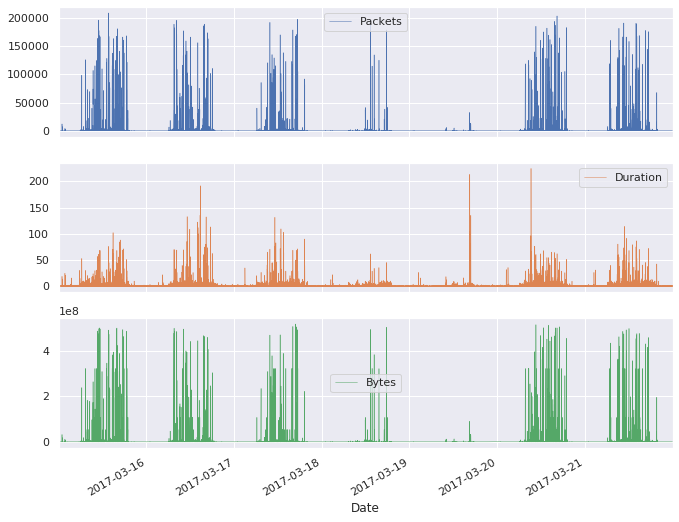

In [36]:
#Some print to see how it looks like

import seaborn as sns

sns.set(rc={'figure.figsize':(11, 9)})
cols_plot=['Packets','Duration','Bytes']
df[cols_plot].plot(linewidth=0.5, subplots=True)

number of rows : 8451520

value repartition for class : 
normal      7010897
attacker     746230
victim       694393
Name: class, dtype: int64



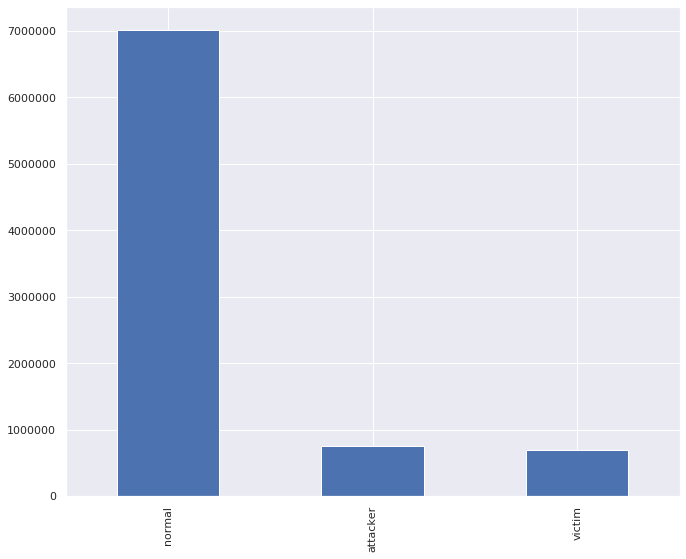

In [37]:
n=df.shape[0]
print("number of rows : "+str(n))
resultat=df['class'].value_counts()
print("\nvalue repartition for class : \n"+str(resultat)+"\n")
resultat=resultat
resultat.plot(kind='bar')

In [0]:
#function to remove some data who are in a certain class
def supprDataAlea(df,clas,nom,frac):
  sus=df.loc[df[clas] == nom]
  sus=sus.sample(frac=frac)
  if frac!=0.0:
    return df.drop(index=sus.index)
  return df

In [0]:
import numpy as np
L = df.shape[0]
Idx = np.random.choice(range(L), int(np.ceil(L/2)))
dfTrain = df.iloc[Idx]


In [0]:
dfTest = df.iloc[~Idx]

In [103]:
dfTrain.head()

,Duration,Proto,Src Pt,Dst Pt,Packets,Bytes,Flags,class
Date,,,,,,,,
2017-03-20 12:25:04.775,0.005,TCP,39420,80.0,6,545.0,.AP.SF,attacker
2017-03-16 15:27:37.209,0.000,TCP,60912,443.0,1,54.0,.A.R..,normal
2017-03-20 16:11:52.114,0.026,TCP,49394,80.0,7,2012.0,.AP...,normal
2017-03-16 13:26:54.681,0.014,TCP,38991,443.0,3,229.0,.AP..F,normal
2017-03-17 12:27:59.317,0.123,TCP,58257,80.0,4,768.0,.AP.S.,normal


In [104]:
dfTest.head()

,Duration,SrcPt,DstPt,Packets,Bytes,ICMP,IGMP,TCP,UDP,Flags_S,Flags_R,Flags_RS,Flags_A,Flags_AF,Flags_AS,Flags_ASF,Flags_AR,Flags_ARF,Flags_ARS,Flags_ARSF,Flags_AP,Flags_APF,Flags_APS,Flags_APSF,Flags_APR,Flags_APRF,Flags_APRS,Flags_APRSF,class_attacker,class_normal,class_victim
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-16 14:14:43.031,0.000,80,44241.0,1,66.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-03-20 11:21:19.852,0.003,35656,53.0,2,158.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-03-16 10:03:44.249,0.000,8082,49194.0,1,200.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2017-03-20 12:27:20.566,0.005,80,48834.0,4,272.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-03-18 13:33:43.955,0.000,443,33075.0,1,100.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [43]:
dfTrain = df.iloc[Idx]
dfTrain.shape

(4225760, 8)

In [44]:
len(Idx)

4225760

In [45]:
n=dfTrain.shape[0]
print("number of rows : "+str(n))
resultat=dfTrain['class'].value_counts()
print("\ndfTrain: value repartition for class : \n"+str(resultat)+"\n")

number of rows : 4225760

dfTrain: value repartition for class : 
normal      3504521
attacker     374035
victim       347204
Name: class, dtype: int64



In [0]:
#suppress data to balance classes
df=supprDataAlea(dfTrain,'class','normal',0.9)
df=supprDataAlea(df,'class','attacker',0.3)
df=supprDataAlea(df,'class','victim',0.3)

number of rows : 548145

value repartition for class : 
normal      187945
attacker    187194
victim      173006
Name: class, dtype: int64



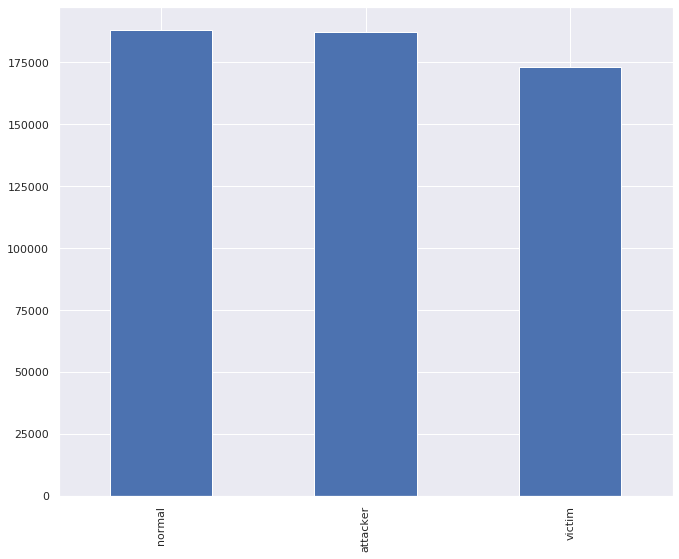

In [47]:
n=df.shape[0]
print("number of rows : "+str(n))
resultat=df['class'].value_counts()
print("\nvalue repartition for class : \n"+str(resultat)+"\n")
resultat=resultat
resultat.plot(kind='bar')

In [48]:
#See the unique values of some features
print(df["Proto"].unique())
print(df["Flags"].unique())
print(df["class"].unique())

['TCP  ' 'UDP  ' 'ICMP ' 'IGMP ']
['.A..SF' '......' '.AP.SF' '.A....' '.AP...' '.AP.S.' '....S.' '.A...F'
 '.AP..F' '.A.R..' '.APRSF' '...RS.' '.APR.F' '.A..S.' '...R..' '.APR..'
 '.APRS.' '.A.R.F' '.A.RS.' '.A.RSF']
['victim' 'normal' 'attacker']


In [49]:
#Proto, Class and Flags become dummy variables

"""
df["Flags"]=df["Flags"].astype("category").cat.codes
df["Proto"]=df["Proto"].astype("category").cat.codes
"""

df= pd.get_dummies(df, columns=['Proto'])


df= pd.get_dummies(df, columns=['Flags'])
df= pd.get_dummies(df, columns=['class'])


df.head()

,Duration,Src Pt,Dst Pt,Packets,Bytes,Proto_ICMP,Proto_IGMP,Proto_TCP,Proto_UDP,Flags_......,Flags_....S.,Flags_...R..,Flags_...RS.,Flags_.A....,Flags_.A...F,Flags_.A..S.,Flags_.A..SF,Flags_.A.R..,Flags_.A.R.F,Flags_.A.RS.,Flags_.A.RSF,Flags_.AP...,Flags_.AP..F,Flags_.AP.S.,Flags_.AP.SF,Flags_.APR..,Flags_.APR.F,Flags_.APRS.,Flags_.APRSF,class_attacker,class_normal,class_victim
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-15 13:41:45.390,0.001,80,59794.0,3,206.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-03-20 08:26:44.408,0.003,48630,53.0,2,154.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-03-15 14:41:13.336,0.004,55578,80.0,5,479.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2017-03-16 15:14:24.304,0.000,443,57857.0,1,66.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-03-21 04:26:42.850,0.002,60101,445.0,2,174.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [0]:
dfTest= pd.get_dummies(dfTest, columns=['Proto'])


dfTest= pd.get_dummies(dfTest, columns=['Flags'])
dfTest= pd.get_dummies(dfTest, columns=['class'])


In [51]:
#bug on Skope Rules because of the space in the features name

df = df.drop(["Flags_......"],axis=1)
df.rename(columns={'Dst Pt':'DstPt',
                   'Src Pt':'SrcPt',
                  'Flags_....S.':'Flags_S',
                  'Flags_...R..':'Flags_R',
                  'Flags_...RS.':'Flags_RS',
                  'Flags_.A...F':'Flags_AF',
                  'Flags_.A....':'Flags_A',
                  'Flags_.A..S.':'Flags_AS',
                  'Flags_.A..SF':'Flags_ASF',
                  'Flags_.A.R..':'Flags_AR',
                  'Flags_.A.R.F':'Flags_ARF',
                  'Flags_.A.RS.':'Flags_ARS',
                  'Flags_.A.RSF':'Flags_ARSF',
                  'Flags_.AP...':'Flags_AP',
                  'Flags_.AP..F':'Flags_APF',
                  'Flags_.AP.S.':'Flags_APS',
                  'Flags_.AP.SF':'Flags_APSF',
                  'Flags_.APR..':'Flags_APR',
                  'Flags_.APR.F':'Flags_APRF',
                  'Flags_.APRS.':'Flags_APRS',
                  'Flags_.APRSF':'Flags_APRSF',
                  'Proto_ICMP ':'ICMP',
                  'Proto_IGMP ':'IGMP',
                  'Proto_TCP  ':'TCP',
                  'Proto_UDP  ':'UDP'},inplace=True)
df.head()

,Duration,SrcPt,DstPt,Packets,Bytes,ICMP,IGMP,TCP,UDP,Flags_S,Flags_R,Flags_RS,Flags_A,Flags_AF,Flags_AS,Flags_ASF,Flags_AR,Flags_ARF,Flags_ARS,Flags_ARSF,Flags_AP,Flags_APF,Flags_APS,Flags_APSF,Flags_APR,Flags_APRF,Flags_APRS,Flags_APRSF,class_attacker,class_normal,class_victim
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-15 13:41:45.390,0.001,80,59794.0,3,206.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-03-20 08:26:44.408,0.003,48630,53.0,2,154.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-03-15 14:41:13.336,0.004,55578,80.0,5,479.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2017-03-16 15:14:24.304,0.000,443,57857.0,1,66.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-03-21 04:26:42.850,0.002,60101,445.0,2,174.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [0]:
#bug on Skope Rules because of the space in the features name

dfTest = dfTest.drop(["Flags_......"],axis=1)
dfTest.rename(columns={'Dst Pt':'DstPt',
                   'Src Pt':'SrcPt',
                  'Flags_....S.':'Flags_S',
                  'Flags_...R..':'Flags_R',
                  'Flags_...RS.':'Flags_RS',
                  'Flags_.A...F':'Flags_AF',
                  'Flags_.A....':'Flags_A',
                  'Flags_.A..S.':'Flags_AS',
                  'Flags_.A..SF':'Flags_ASF',
                  'Flags_.A.R..':'Flags_AR',
                  'Flags_.A.R.F':'Flags_ARF',
                  'Flags_.A.RS.':'Flags_ARS',
                  'Flags_.A.RSF':'Flags_ARSF',
                  'Flags_.AP...':'Flags_AP',
                  'Flags_.AP..F':'Flags_APF',
                  'Flags_.AP.S.':'Flags_APS',
                  'Flags_.AP.SF':'Flags_APSF',
                  'Flags_.APR..':'Flags_APR',
                  'Flags_.APR.F':'Flags_APRF',
                  'Flags_.APRS.':'Flags_APRS',
                  'Flags_.APRSF':'Flags_APRSF',
                  'Proto_ICMP ':'ICMP',
                  'Proto_IGMP ':'IGMP',
                  'Proto_TCP  ':'TCP',
                  'Proto_UDP  ':'UDP'},inplace=True)


In [0]:
#Preprocessing the data
import sklearn

df=sklearn.utils.shuffle(df)

label_names=["class_attacker","class_normal","class_victim"]
features=df.drop(label_names,axis=1).values
label=df[label_names].values

test_size=(int)(n*(1/3))

X_train=features[:-test_size]
y_train=label[:-test_size]

X_test=features[-test_size:]
y_test=label[-test_size:]

In [0]:
features_names = df.drop(label_names,axis=1).columns

In [0]:
llabel_names=["class_attacker","class_normal","class_victim"]
ffeatures=dfTest.drop(label_names,axis=1).values
llabel=dfTest[label_names].values

XX_test=ffeatures
yy_test=llabel

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def ROCCurve(y_score,zoomed=True):
  lw=2
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= 3

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(2)
  plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(3), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(label_names[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()
  
  if zoomed:
    # ZOOMED
    plt.figure(3)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(label_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 0.2])
    plt.ylim([0.8, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zoomed')
    plt.legend(loc="lower right")
    plt.show()

In [58]:
"""
# Test to see with how many neigbours it is the most accurate

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 
    
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()
"""

"\n# Test to see with how many neigbours it is the most accurate\n\n#Setup arrays to store training and test accuracies\nneighbors = np.arange(1,9)\ntrain_accuracy =np.empty(len(neighbors))\ntest_accuracy = np.empty(len(neighbors))\n\nfor i,k in enumerate(neighbors):\n    #Setup a knn classifier with k neighbors\n    knn = KNeighborsClassifier(n_neighbors=k)\n    \n    #Fit the model\n    knn.fit(X_train, y_train)\n    \n    #Compute accuracy on the training set\n    train_accuracy[i] = knn.score(X_train, y_train)\n    \n    #Compute accuracy on the test set\n    test_accuracy[i] = knn.score(X_test, y_test) \n    \n#Generate plot\nplt.title('k-NN Varying number of neighbors')\nplt.plot(neighbors, test_accuracy, label='Testing Accuracy')\nplt.plot(neighbors, train_accuracy, label='Training accuracy')\nplt.legend()\nplt.xlabel('Number of neighbors')\nplt.ylabel('Accuracy')\nplt.show()\n"

## KNN


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

knn1 = KNeighborsClassifier(n_neighbors=2)
y_pred=knn1.fit(X_train,y_train)

y_pred=y_pred.predict(X_test) # prediction with balanced classes

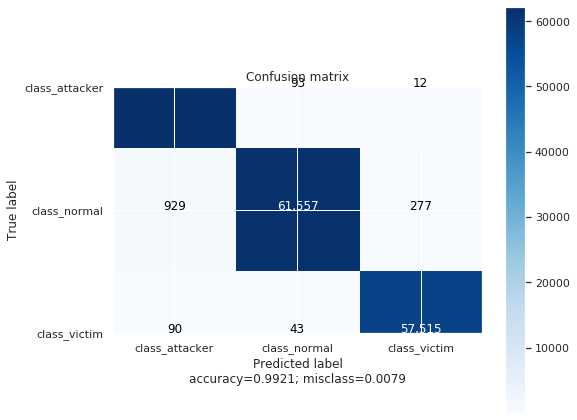

                precision    recall  f1-score   support

class_attacker     0.9964    0.9962    0.9963     62304
  class_normal     0.9978    0.9808    0.9892     62763
  class_victim     0.9950    0.9977    0.9963     57648

     micro avg     0.9964    0.9914    0.9939    182715
     macro avg     0.9964    0.9916    0.9940    182715
  weighted avg     0.9964    0.9914    0.9939    182715
   samples avg     0.9914    0.9914    0.9914    182715



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
plot_confusion_matrix(cm,target_names=label_names, normalize=False)
print(classification_report(y_test,y_pred,target_names=label_names, digits=4))

#y_scoreKNN=knn1.predict_proba(X_test)

#ROCCurve(y_scoreKNN)

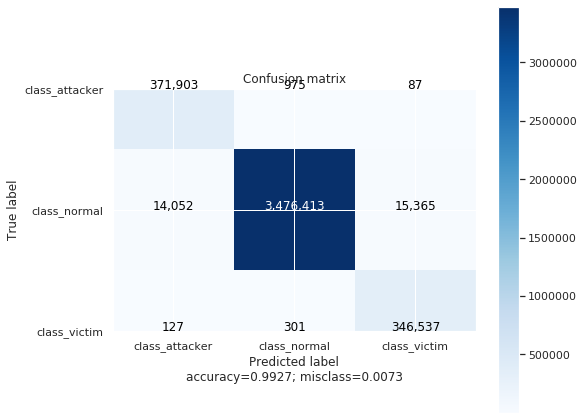

                precision    recall  f1-score   support

class_attacker     0.9633    0.9972    0.9799    372965
  class_normal     0.9996    0.9916    0.9956   3505830
  class_victim     0.9573    0.9988    0.9776    346965

     micro avg     0.9927    0.9927    0.9927   4225760
     macro avg     0.9734    0.9958    0.9844   4225760
  weighted avg     0.9929    0.9927    0.9927   4225760
   samples avg     0.9927    0.9927    0.9927   4225760



In [67]:
# Performances on half the dataset which was put aside
y_predKnn=knn1.predict(XX_test)

cmKnn=confusion_matrix(yy_test.argmax(axis=1),y_predKnn.argmax(axis=1))

plot_confusion_matrix(cmKnn,target_names=label_names, normalize=False)
print(classification_report(yy_test,y_predKnn,target_names=label_names, digits=4))


## DECISION TREE

In [0]:
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier

#ctree = OneVsRestClassifier(tree.DecisionTreeClassifier()) # Compute with one vs all th erest
ctree = tree.DecisionTreeClassifier() # compute for the three classes

clftree = ctree.fit(X_train,y_train)

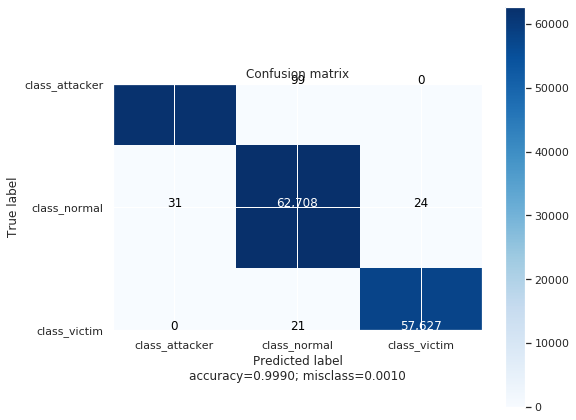

                precision    recall  f1-score   support

class_attacker     0.9995    0.9984    0.9990     62304
  class_normal     0.9981    0.9991    0.9986     62763
  class_victim     0.9996    0.9996    0.9996     57648

     micro avg     0.9991    0.9990    0.9990    182715
     macro avg     0.9991    0.9991    0.9991    182715
  weighted avg     0.9991    0.9990    0.9990    182715
   samples avg     0.9990    0.9990    0.9990    182715



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [89]:
y_predTree=clftree.predict(X_test)

cmTree=confusion_matrix(y_test.argmax(axis=1),y_predTree.argmax(axis=1))

plot_confusion_matrix(cmTree,target_names=label_names, normalize=False)
print(classification_report(y_test,y_predTree,target_names=label_names, digits=4))

try:
  y_scoreTree=ctree.predict_proba(X_test)
  ROCCurve(y_scoreTree)
except:
  pass  

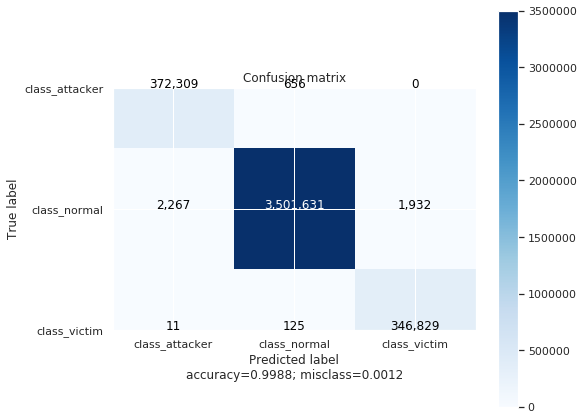

                precision    recall  f1-score   support

class_attacker     0.9941    0.9982    0.9962    372965
  class_normal     0.9998    0.9988    0.9993   3505830
  class_victim     0.9945    0.9996    0.9970    346965

     micro avg     0.9988    0.9988    0.9988   4225760
     macro avg     0.9961    0.9989    0.9975   4225760
  weighted avg     0.9988    0.9988    0.9988   4225760
   samples avg     0.9988    0.9988    0.9988   4225760



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [90]:
y_predTree=clftree.predict(XX_test)

cmTree=confusion_matrix(yy_test.argmax(axis=1),y_predTree.argmax(axis=1))

plot_confusion_matrix(cmTree,target_names=label_names, normalize=False)
print(classification_report(yy_test,y_predTree,target_names=label_names, digits=4))

### Plotting the tree

In [0]:
# The export_text has issues if we present multiclasses in "dummy/binary" form. 
# Thus we change the numbering of categories as "2" for class 0 "attacker", "1" for class 1 "normal", and "0" for class 2 "victim"

def f(x):
  return 2*x[0]+1*x[1]+0*x[2]
y_train_ = list(map(f,y_train))
y_test_ = list(map(f,y_test))

cctree = tree.DecisionTreeClassifier()
cclftree = cctree.fit(X_train,y_train_)

In [112]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(cctree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("cctree") 
r = tree.export_text(cctree, feature_names=list(features_names))
print(r)


|--- Flags_ASF <= 0.50
|   |--- Flags_APSF <= 0.50
|   |   |--- Flags_S <= 0.50
|   |   |   |--- Flags_AR <= 0.50
|   |   |   |   |--- DstPt <= 37.50
|   |   |   |   |   |--- DstPt <= 3.20
|   |   |   |   |   |   |--- IGMP <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- IGMP >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- DstPt >  3.20
|   |   |   |   |   |   |--- Flags_AP <= 0.50
|   |   |   |   |   |   |   |--- DstPt <= 5.70
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- DstPt >  5.70
|   |   |   |   |   |   |   |   |--- Bytes <= 3233.00
|   |   |   |   |   |   |   |   |   |--- SrcPt <= 55799.00
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- SrcPt >  55799.00
|   |   |   |   |   |   |   |   |   |   |--- Flags_RS <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- Flags_RS >  0.50
|   |   | 

In [0]:
# This transforms the tree into code: running this code on an instance will predict the classification with 99.88% accuracy..

# from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

import numpy as np
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] 
                    if i != _tree.TREE_UNDEFINED else "undefined!" 
                    for i in tree_.feature]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node])))

    recurse(0, 1)

In [114]:
# generating the classification code
tree_to_code(cctree, feature_names=list(features_names))


def tree(Duration, SrcPt, DstPt, Packets, Bytes, ICMP, IGMP, TCP, UDP, Flags_S, Flags_R, Flags_RS, Flags_A, Flags_AF, Flags_AS, Flags_ASF, Flags_AR, Flags_ARF, Flags_ARS, Flags_ARSF, Flags_AP, Flags_APF, Flags_APS, Flags_APSF, Flags_APR, Flags_APRF, Flags_APRS, Flags_APRSF):
    if Flags_ASF <= 0.5:
        if Flags_APSF <= 0.5:
            if Flags_S <= 0.5:
                if Flags_AR <= 0.5:
                    if DstPt <= 37.5:
                        if DstPt <= 3.1999999284744263:
                            if IGMP <= 0.5:
                                return 0
                            else:  # if IGMP > 0.5
                                return 1
                        else:  # if DstPt > 3.1999999284744263
                            if Flags_AP <= 0.5:
                                if DstPt <= 5.700000047683716:
                                    return 1
                                else:  # if DstPt > 5.700000047683716
                                    if Byt

In [115]:
# Tree characteristics
print("max depth", cctree.tree_.max_depth)
print("node count", cctree.tree_.node_count)
print("leaves", cctree.tree_.n_leaves)

max depth 31
node count 563
leaves 282


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


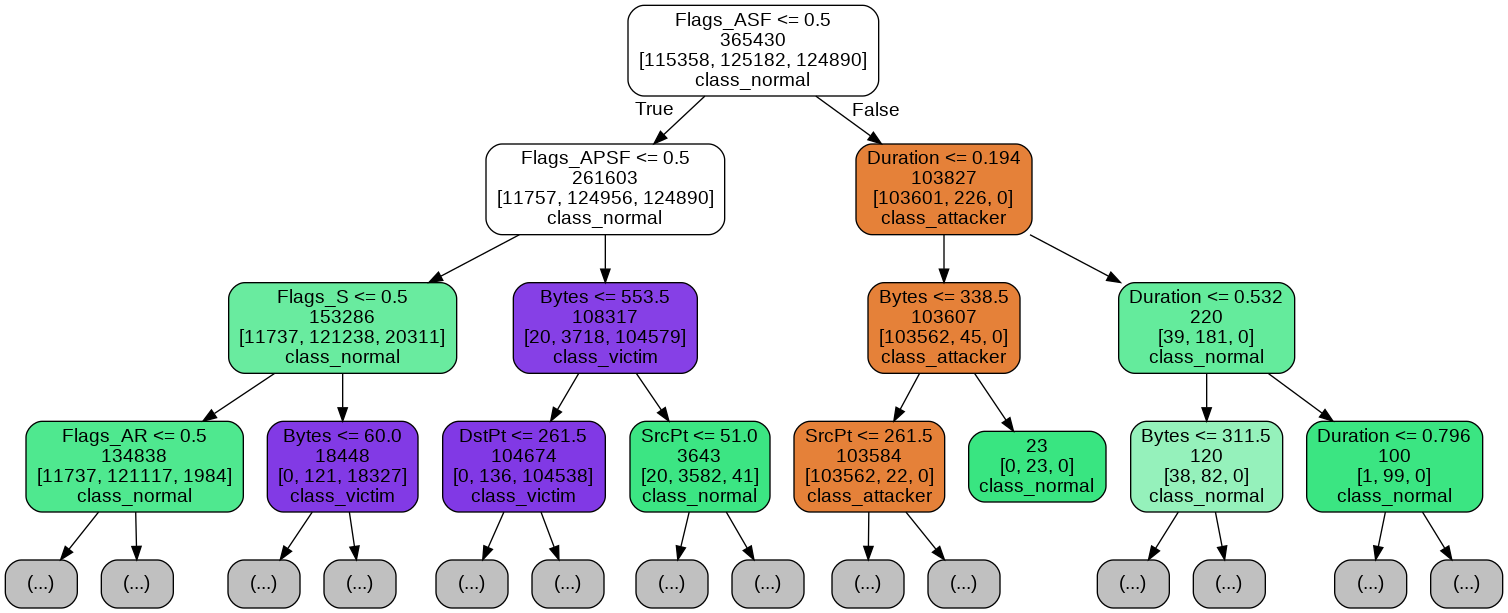

In [118]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
#export_graphviz(cctree, out_file=dot_data,  
#                filled=True, rounded=True,
#                special_characters=True)
export_graphviz(cctree, out_file=dot_data, 
                      feature_names=features_names,
                      class_names=label_names,
                      label=None,
                      impurity=False,                   
                      max_depth=3,  
                      filled=True, rounded=True,  
                      special_characters=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [0]:
print(ccctre.tree_.max_depth)

## XGBoost


In [0]:
def f(x):
  return 2*x[0]+1*x[1]+0*x[2]
yxgb_train = list(map(f,y_train))
yxgb_test = list(map(f,y_test))

In [0]:
from xgboost import XGBClassifier
# create a default XGBoost classifier
model = XGBClassifier(n_estimators=100, n_jobs=-1, random_state=43)
model.fit(X_train, yxgb_train)
y_predForest=model.predict(X_test)

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
cmForest=confusion_matrix(yxgb_test,y_predForest)

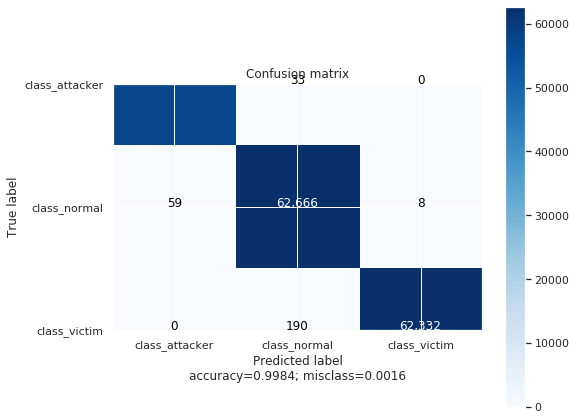

In [0]:
plot_confusion_matrix(cmForest,target_names=label_names, normalize=False)

In [0]:
print(classification_report(yxgb_test,y_predForest,target_names=label_names, digits=4))

                precision    recall  f1-score   support

class_attacker     0.9997    0.9996    0.9997     57155
  class_normal     0.9981    0.9997    0.9989     62666
  class_victim     1.0000    0.9984    0.9992     62668

      accuracy                         0.9992    182489
     macro avg     0.9993    0.9992    0.9993    182489
  weighted avg     0.9992    0.9992    0.9992    182489



In [0]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
param_grid = {'n_estimators': [100], 'criterion':['gini', 'entropy'], 
              'max_features': ['auto', 2, 6, 8], 'max_depth':[10,20,30,None]}
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100],
    "n_jobs":[-1],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}              
model = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy')
model.fit(X_train,yxgb_train) # ~~VERY~~ HORRIBLY LONG!!
print(model.best_estimator_)
'''

## RANDOM FOREST


### Choosing the best parameters

In [0]:
"""from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
param_grid = {'n_estimators': [100], 'criterion':['gini', 'entropy'], 
              'max_features': ['auto', 2, 6, 8], 'max_depth':[10,20,30,None]}
model = GridSearchCV(estimator=RF, param_grid=param_grid, cv=10, scoring='accuracy')
#model.fit(X_train,y_train)
#print(model.best_estimator_)
"""

In [0]:
"""model.fit(X_train,y_train)"""

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=800, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=True),
             iid='war

In [0]:
#model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=True)

### Identifying and running the model


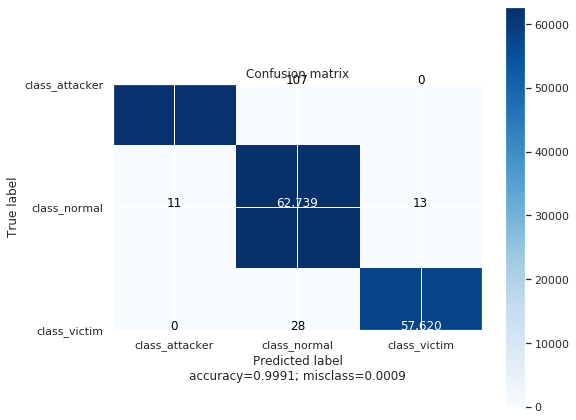

                precision    recall  f1-score   support

class_attacker     0.9998    0.9983    0.9991     62304
  class_normal     0.9979    0.9996    0.9987     62763
  class_victim     0.9998    0.9995    0.9996     57648

     micro avg     0.9991    0.9991    0.9991    182715
     macro avg     0.9992    0.9991    0.9991    182715
  weighted avg     0.9991    0.9991    0.9991    182715
   samples avg     0.9991    0.9991    0.9991    182715



In [119]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

#RF=OneVsRestClassifier(RandomForestClassifier(n_estimators=800, n_jobs=-1, warm_start=True))
# RF with best parameters
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=True)

clfForest=RF.fit(X_train,y_train)

y_predForest=clfForest.predict(X_test)

cmForest=confusion_matrix(y_test.argmax(axis=1),y_predForest.argmax(axis=1))

plot_confusion_matrix(cmForest,target_names=label_names, normalize=False)
print(classification_report(y_test,y_predForest,target_names=label_names, digits=4))

y_scoreForest=RF.predict_proba(X_test)

# ROCCurve(y_scoreForest)

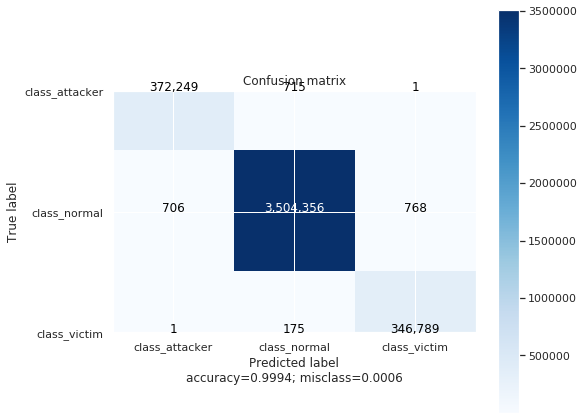

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

class_attacker     0.9982    0.9981    0.9981    372965
  class_normal     0.9997    0.9996    0.9997   3505830
  class_victim     0.9978    0.9995    0.9986    346965

     micro avg     0.9994    0.9994    0.9994   4225760
     macro avg     0.9986    0.9990    0.9988   4225760
  weighted avg     0.9994    0.9994    0.9994   4225760
   samples avg     0.9994    0.9994    0.9994   4225760



In [120]:
# Performances evaluated on half of the original imbalanced data
y_predTree=RF.predict(XX_test)

cmTree=confusion_matrix(yy_test.argmax(axis=1),y_predTree.argmax(axis=1))

plot_confusion_matrix(cmTree,target_names=label_names, normalize=False)
print(classification_report(yy_test,y_predTree,target_names=label_names, digits=4))

y_scoreTree=ctree.predict_proba(XX_test)

### Importances features


Text(0.5, 0, 'Relative Importance')

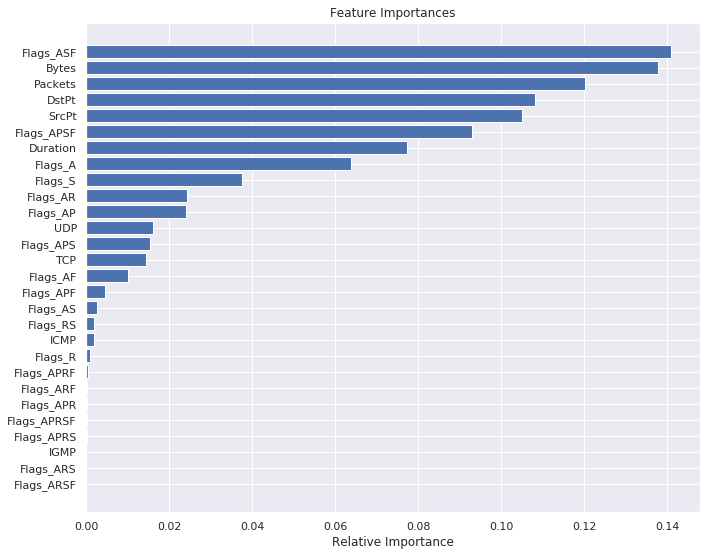

In [0]:
importances = RF.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_names[i] for i in indices])
plt.xlabel('Relative Importance')

**NEURAL NETWORK**





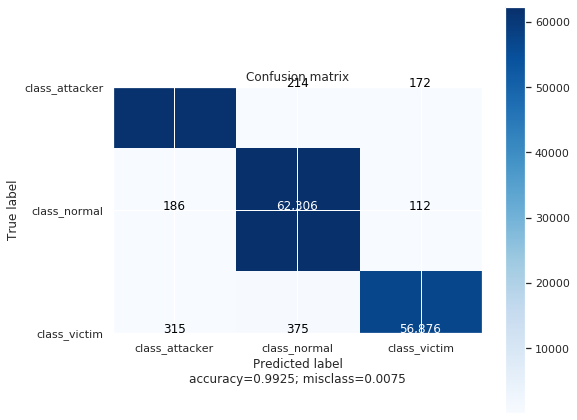

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

class_attacker     0.9929    0.9938    0.9933     61979
  class_normal     0.9906    0.9962    0.9934     62604
  class_victim     0.9914    0.9883    0.9899     57566

     micro avg     0.9916    0.9929    0.9923    182149
     macro avg     0.9916    0.9928    0.9922    182149
  weighted avg     0.9917    0.9929    0.9923    182149
   samples avg     0.9921    0.9929    0.9923    182149



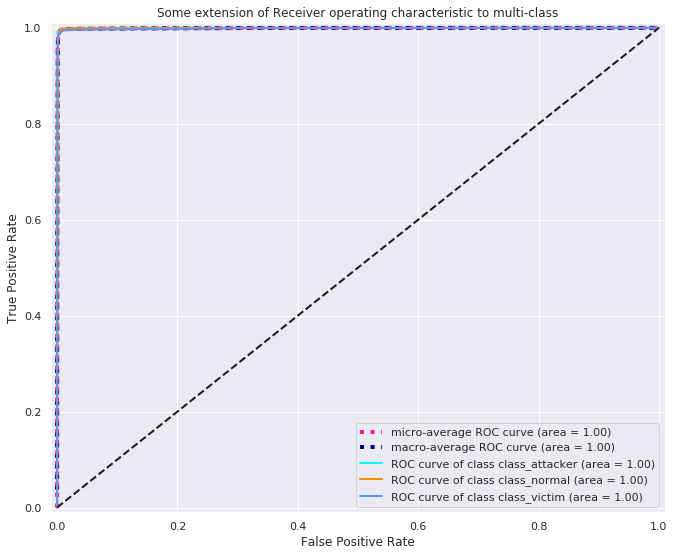

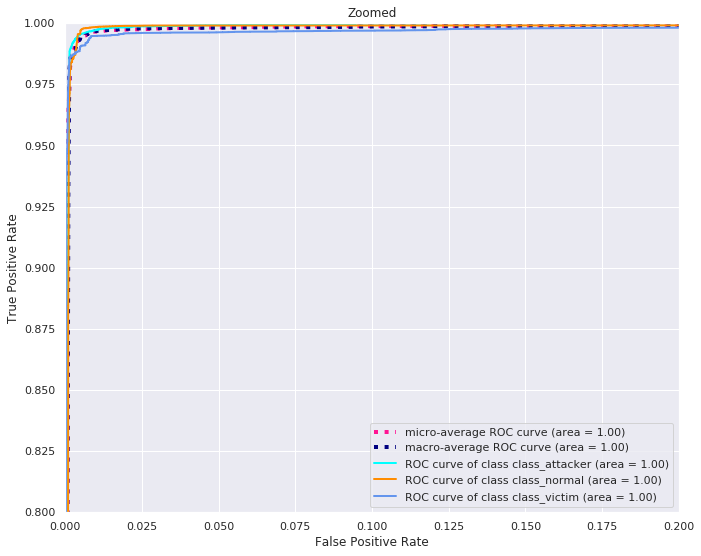

In [0]:
from sklearn.neural_network import MLPClassifier

#NN=OneVsRestClassifier(MLPClassifier(max_iter=200))
NN=MLPClassifier(max_iter=200)
clfNN=NN.fit(X_train,y_train)

y_predNN=clfNN.predict(X_test)

cmNN=confusion_matrix(y_test.argmax(axis=1),y_predNN.argmax(axis=1))

plot_confusion_matrix(cmNN,target_names=label_names, normalize=False)
print(classification_report(y_test,y_predNN,target_names=label_names, digits=4))

y_scoreNN=NN.predict_proba(X_test)

ROCCurve(y_scoreNN)